# Metatranscriptome data synthesis and plotting:

In [1]:
#Make sure these are all installed!
library(edgeR)
library(plyr)
library(dplyr)
library(reshape2)
library(ggplot2)
library(ggtern)
library(UpSetR)
library(vegan)

Loading required package: limma

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

--
Consider donating at: http://ggtern.com
Even small amounts (say $10-50) are very much appreciated!
Remember to cite, run citation(package = 'ggtern') for further info.
--

Attaching package: ‘ggtern’

The following objects are masked from ‘package:ggplot2’:

    %+%, aes, annotate, calc_element, ggplot, ggplot_build,
    ggplot_gtable, ggplotGrob, ggsave, layer_data, theme, theme_bw,
    theme_classic, theme_dark, theme_gray, theme_light, theme_linedraw,
    theme_minimal, theme_void

Loading required package: permute
Loading required package: lattice

Attaching package: ‘lattice’

The following object is masked from ‘pack

# EdgeR normalization and importing annotation information

In [2]:
#from python script - OrthoMCL parsing
rawdata<-read.csv("RawCounts_bycontig_annotated.csv", header=TRUE)
head(rawdata); names(rawdata)

X,K0_number,Level2,Depth,Cluster,Count,Sample10,Sample11,Sample12,Sample25,Sample26,Sample27,Sample28,Sample29,Sample30,Sample31,Sample7,Sample8,Sample9
k99_1000000_deep890m,,Unannotated,deep890m,Cluster 83763,0,0,0,0,0,0,0,19,56,34,54,0,0,0
k99_1000000_surface,,Unannotated,surface,Cluster 2817082,0,1,2,0,0,0,0,0,0,0,0,0,0,0
k99_1000001_deep890m,,Uncertain,deep890m,Cluster 225311,0,0,0,0,4,0,7,3,7,12,7,0,0,0
k99_1000001_surface,,Unannotated,surface,Cluster 3149625,0,0,0,2,0,0,0,0,0,0,0,0,1,2
k99_1000005_deep150m,K01099,Ciliate,deep150m,Cluster 2358053,0,0,0,0,4,8,1,0,0,0,0,0,0,0
k99_1000005_deep890m,,Unannotated,deep890m,Cluster 30751,0,0,0,0,0,0,0,5,25,10,5,0,0,0


[1] "X"         "K0_number" "Level2"    "Depth"     "Cluster"   "Count"    
 [7] "Sample10"  "Sample11"  "Sample12"  "Sample25"  "Sample26"  "Sample27" 
[13] "Sample28"  "Sample29"  "Sample30"  "Sample31"  "Sample7"   "Sample8"  
[19] "Sample9"

In [ ]:
#To run through script with a small dataset use:
#rawdata<-read.csv("test_file_05022017.csv")

In [3]:
#Normalize among replicates
countfile<-rawdata[c(1:3,5,17:19,7:9,10:16)] #reorder columns so samples are in a row, Remove "Depth" and "Count" excess. 
dge.metaT<-DGEList(counts=countfile[,5:17],genes=countfile[1:4],group=c(rep("Surface",6),rep("Deep_150m",3),rep("Deep_890m",4)))
dge.metaT$samples
data<-calcNormFactors(dge.metaT,method = "TMM")
#plotMDS(data) #Option to plot in ordination space
cpm_data<-cpm(data, normalized.lib.sizes=TRUE, log=FALSE) #obtain only CPM (not logged)
cpm_data<-as.data.frame(cpm_data)  
data_CPM<-data.frame(data$genes,cpm_data)
#Calculate mean transcript CPM across replicates
data_CPM$MeanCPM_surface<-apply(data_CPM[5:10],1,FUN=mean)
data_CPM$MeanCPM_150m<-apply(data_CPM[11:13],1,FUN=mean)
data_CPM$MeanCPM_890m<-apply(data_CPM[14:17],1,FUN=mean)
#Output data_CPM has all data normalized between samples (depths).

,group,lib.size,norm.factors
Sample7,Surface,8035213,1
Sample8,Surface,4520002,1
Sample9,Surface,10514422,1
Sample10,Surface,13584570,1
Sample11,Surface,10822012,1
Sample12,Surface,9054206,1
Sample25,Deep_150m,18823004,1
Sample26,Deep_150m,11694061,1
Sample27,Deep_150m,21877382,1
Sample28,Deep_890m,6080055,1


## Generate Figure 2 bar plots
#### First import annotation information (in the form of R objects)

In [4]:
#Import taxonomic group names
key.wtax<-read.delim("TaxaName_bycontig.txt", header=TRUE, sep="\t")
head(key.wtax)

contig_ID,K0_number,Level2,Taxa
k99_10000_surface,K13789,Haptophyte,Haptophyte
k99_1000000_surface,NA,NA from database,NA from database
k99_1000002_surface,NA,NA from database,NA from database
k99_1000006_surface,NA,NA from database,NA from database
k99_1000007_surface,K13025,Chlorophyte,Chlorophyte
k99_1000008_surface,NA,Pelagophyceae,Other eukaryote


In [5]:
names(data_CPM)

[1] "X"               "K0_number"       "Level2"          "Cluster"        
 [5] "Sample7"         "Sample8"         "Sample9"         "Sample10"       
 [9] "Sample11"        "Sample12"        "Sample25"        "Sample26"       
[13] "Sample27"        "Sample28"        "Sample29"        "Sample30"       
[17] "Sample31"        "MeanCPM_surface" "MeanCPM_150m"    "MeanCPM_890m"

In [6]:
#Bar plot to show mean relative abundance of taxonomic groups based on transcript abundances
contigTax<-data_CPM[c(1,18:20)] #isolate columns with mean CPM
colnames(contigTax)[1]<-"contig_ID"
contigTax2<-join(contigTax, key.wtax) #full taxa
MeanCPM_tax<-contigTax2[c(6:7,2:4)]

#Sum by mean transcript CPM
MeanCPM_tax_sum<-aggregate(MeanCPM_tax[3:5], by=list(Taxa=MeanCPM_tax$Taxa),sum)
m_tax_agg<-melt(MeanCPM_tax_sum)

#Factoring - set up for plot
variable<-c("MeanCPM_890m","MeanCPM_150m","MeanCPM_surface")
m_tax_agg$var<-factor(m_tax_agg$variable, levels=variable)
tax_order=c("Dinoflagellate","Ciliate","Haptophyte","Diatom","Chlorophyte","Other eukaryote","Metazoa", "Multiple hits", "NA from database")
tax_color=c("#ca0020","#ec7014","#4eb3d3","#fee391","#238b45","#807dba","#737373","#bdbdbd","#ffffff")
names(tax_color)<-tax_order
colScale<-scale_colour_manual(values=tax_color)
m_tax_agg$tax<-factor(m_tax_agg$Taxa, levels=rev(tax_order))

Joining by: contig_ID
Using Taxa as id variables


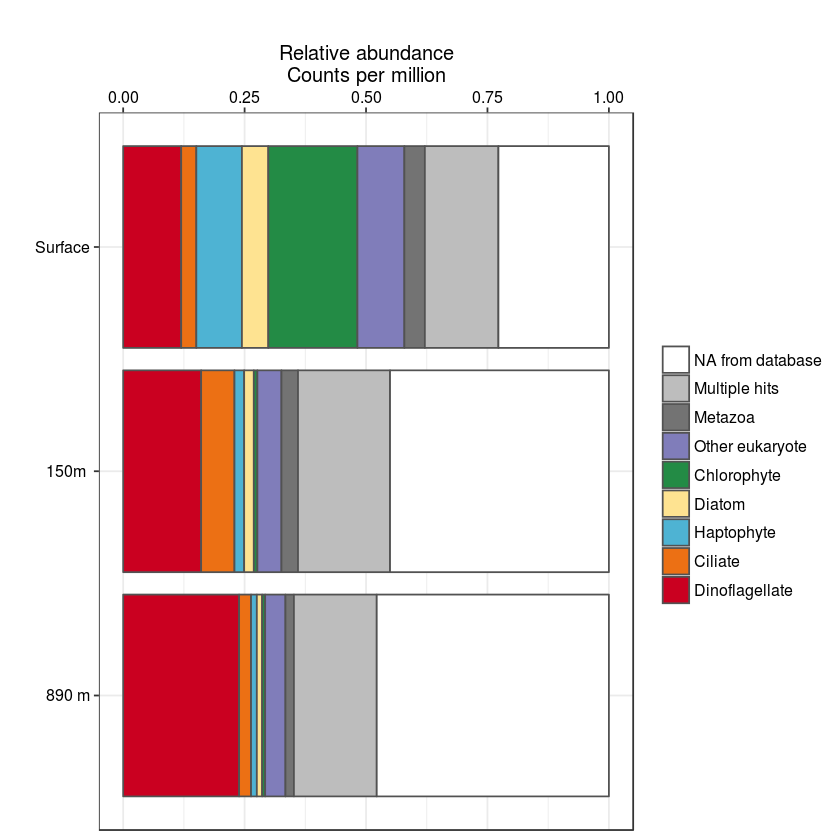

In [7]:
plot_tax<-ggplot(m_tax_agg[order(m_tax_agg$tax),],aes(y=value,x=var,fill=tax))+geom_bar(stat="identity", position="fill", color="#525252")+labs(title="", x="",y="Relative abundance\nCounts per million")+theme_bw()+scale_x_discrete(labels=c("890 m","150m ","Surface"))+scale_fill_manual(values=tax_color)+coord_flip()+scale_y_continuous(position = "top")+theme(legend.title=element_blank(),legend.position="right",legend.text.align=0, axis.text = element_text(color="black"))
plot_tax

In [ ]:
#For supplementary Table about taxonomic composition
#suppTable<-aggregate(MeanCPM_tax[3:5], by=list(Taxa=MeanCPM_tax$Taxa, Taxa2=MeanCPM_tax$Level2),sum)
#write.csv(suppTable, file="Supple_TaxTable.csv")

## UpsetR plot, Figure 3

In [ ]:
#library(UpSetR)

In [ ]:
#Contig and ortholog distribution import (from Parse and compile python script)
tax_binary<-read.csv("Ortho_groups_by_taxa_binary.csv")
depth_binary<-read.csv("Ortho_by_depth_Binary.csv")

In [ ]:
length(unique(depth_binary$Cluster))
annot<-read.delim("Annotated_withKO_ids.txt",header=F); colnames(annot)[1]<-"Cluster"; annot$annot<-"Annotated" #Import, change name, add a column
depth_bin_annt<-join(depth_binary, annot, by="Cluster",type="left")

#Relabel "NAs"
depth_bin_annt[is.na(depth_bin_annt)]<-"Unannotated"
unique(depth_bin_annt$annot)

#Plot Figure 3:
upset(depth_bin_annt,nsets=3,keep.order = TRUE,sets=c("deep890m", "deep150m", "surface"),order.by="freq",text.scale = 2,queries = list(list(query=intersects, params=list("annot","Annotated"),color="grey",active=TRUE)), mainbar.y.label = "Shared ortholog groups", sets.x.label = "Total ortholog groups", sets.bar.color = "#addd8e",query.legend = "bottom")

In [ ]:
#Figure S4
upset(tax_binary,nsets=5,keep.order = TRUE,text.scale = 1, sets=c("Dinoflagellate", "Ciliate", "Haptophyte", "Diatom", "Chlorophyte"),number.angles = 45)

## Ternary plots
### whole community

In [ ]:
#Take CPM data, sum by labeled CPM
#library(ggplot2)
#library(ggtern)

#start with data_CPM
#head(data_CPM)
#Import annotation information by contig
K0_labeled<-read.delim("AnnotationInfo_bycontig.txt",sep="\t",header=TRUE)

In [ ]:
#Add Kegg and labeled info to CPM df
CPM_wAnnot<-join(data_CPM, K0_labeled)
#Rows will be repeated.
dim(data_CPM); dim(CPM_wAnnot) #CPM_wAnnot >> data_CPM wrt lines

In [ ]:
#Format for plots:
CPM_wAnnot.m<-melt(CPM_wAnnot[c(1:3,18:20, 5:17,21:26)])
CPM_wAnnot.m.norm<-subset(CPM_wAnnot.m, !(value<0)) #Option to remove genes based on CPM value. 
CPM_wAnnot.m.norm.noNA<-CPM_wAnnot.m.norm[!is.na(CPM_wAnnot.m.norm$Label),] 
#length(unique(CPM_wAnnot.m.norm.noNA$K0_number)) #Should be 10224 unique Kegg IDs
tmp<-CPM_wAnnot.m.norm.noNA[c(2:4,9:11)] #remove the columns with any NAs
tmp2<-tmp[!duplicated(tmp),] #remove duplicates, now that the A-C levels are gone. #duplicates are removed... but if a gene falls into multiple "labels" it is kept as such...
tri_input<-dcast(tmp2, K0_number+Label+Level2+Gene_identification~variable,fun.aggregate = sum)


In [ ]:
#Targetted metabolic pathways and genes
paths<-c("Photosynthesis","Calvin cycle","Glycolysis","Gluconeogenesis","AMT","NRT","Nitrate reduction (assimilatory)","GS/GOGAT","PDH","por","Urea cycle","Fatty acid biosynthesis","Fatty acid breakdown","TCA cycle","Glyoxylate cycle","V-type ATPase","Lysosome associated","Chitinase")

In [ ]:
#Generate ternary plot:
#use means:
tri_mean<-tri_input[c(1:7)]
tri_whole<-aggregate(tri_mean[5:7], by=list(Label=tri_mean$Label),sum)
tri_whole$sum<-apply(tri_whole[2:4],1,FUN=sum)
tri_whole<-subset(tri_whole, Label %in% paths) #only grab things that are in path!

#Factoring:
tri_whole$pathway<-factor(tri_whole$Label, levels=paths)
path_color<-c("#b2df8a","#33a02c","#a6cee3","#1f78b4","#e31a1c","#fed976","#e7298a","#c7e9b4","#f03b20","#fd8d3c","#662506","#9e9ac8","#54278f","#01665e","#80cdc1","#ffffff","#878787","#000000")
names(path_color)<-paths
colScale<-scale_colour_manual(values=path_color)

#Plot:
plot_tri_whole<-ggtern(tri_whole,aes(MeanCPM_surface, MeanCPM_150m,MeanCPM_890m))+geom_point(shape=21,aes(size=sum))+theme_rgbg()+ scale_size(range = c(4,20))+theme_custom(base_size = 12, base_family = "",tern.plot.background = "transparent", tern.panel.background = "#d9d9d9",col.T = "#fd8d3c", col.L = "#cb181d", col.R = "#2171b5",col.grid.minor = "white")+ theme_showarrows()+theme_rotate(degrees = 240)+theme_clockwise()+theme(legend.title = element_text(size=16, face="bold"),legend.key=element_rect(fill='white'))+labs(title="",x="Surface",y="150m",z="890m")+labs(size="Relative CPM", label="Pathway")+scale_fill_manual(values=path_color) #path_color
plot_tri_whole+geom_point(shape=21,aes(size=sum,fill=pathway))

## Use tri_plot again to generate ternary plots by taxonomic group:

In [ ]:
#format plot:
tri_mean<-tri_input[c(1:7)]
tri_mean_sub<-subset(tri_mean, Label %in% paths)
tri_tax.m<-melt(tri_mean_sub)
tmp3<-aggregate(tri_tax.m$value, by=list(var=tri_tax.m$variable, Label=tri_tax.m$Label, Taxa=tri_tax.m$Level2),sum)

#Calculate relative abundance BY tax and depth - Normalization step
library(dplyr)
tmp3_relAbun<-tmp3 %>% group_by(var, Taxa) %>% mutate(Relabun=x/sum(x))
tmp3_relAbun<-as.data.frame(tmp3_relAbun)
names(tmp3_relAbun)
tri_wtax_agg<-dcast(tmp3_relAbun[c(1:3,5)],Label+Taxa~var)
tri_wtax_agg[is.na(tri_wtax_agg)]<-0


#Format and factor for ternary plot
tri_wtax_agg$sum<-apply(tri_wtax_agg[3:5],1,FUN=sum) #get sums
tri_wtax_agg$pathway<-factor(tri_wtax_agg$Label, levels=paths)
path_color<-c("#b2df8a","#33a02c","#a6cee3","#1f78b4","#fed976","#fed976","#fa9fb5","#fa9fb5","#fd8d3c","#fd8d3c","#e31a1c","#9e9ac8","#54278f","#80cdc1","#80cdc1","#ffffff","#878787","#000000")
names(path_color)<-paths
colScale<-scale_colour_manual(values=path_color)
unique(tri_wtax_agg$Label)
tax_order<-c("Dinoflagellate", "Ciliate","Haptophyte", "Diatom", "Chlorophyte")
tri_wtax_agg$Taxa_order<-factor(tri_wtax_agg$Taxa, levels=tax_order)

In [ ]:
#Plot:
#library(ggtern)
plot_tri_gene_tax<-ggtern(tri_wtax_agg[order(tri_wtax_agg$Taxa_order),],aes(MeanCPM_surface, MeanCPM_150m,MeanCPM_890m))+geom_point(shape=21,aes(size=sum,fill=pathway))+theme_rgbg()+ scale_size(range = c(2,10))+theme_custom(base_size = 8, base_family = "",tern.plot.background = "transparent", tern.panel.background = "#d9d9d9",col.T = "#fd8d3c", col.L = "#cb181d", col.R = "#2171b5",col.grid.minor = "white")+ theme_showarrows()+theme_rotate(degrees = 240)+theme_clockwise()+theme(legend.title = element_text(size=10, face="bold"),legend.key=element_rect(fill='transparent'))+labs(title="",x="Surface",y="150m",z="890m")+labs(size="Relative CPM", label="Pathway")+scale_fill_manual(values=path_color)
plot_tri_gene_tax %+% subset(tri_wtax_agg, Taxa %in% tax_order) + facet_wrap(~Taxa_order, ncol=3) + guides(fill=FALSE)

# Generate CCA plot:

In [ ]:
#CCA plot: Input COMMON K0s across taxonomic groups. Input .csv file created in python notebook
countfile_commonKO<-read.csv("Raw_Counts_ByTaxa_CommonKO.csv") #raw count file
dim(countfile_commonKO) #>8,000 contigs compiled, where accepted contigs for analysis had to have at least 1 count for K0 ID and taxonomic group
#length(unique(countfile_commonKO$K0_number)) #n=1603
#names(countfile_commonKO)
countfile<-countfile_commonKO[c(1:2,13:15,3:5,6:12)]

In [ ]:
#Normalize again, similar to above
#library(edgeR)
dge.metaT.cca<-DGEList(counts=countfile[,3:15],genes=countfile[1:2],group=c(rep("Surface",6),rep("Deep_150m",3),rep("Deep_890m",4)))
dge.metaT.cca$samples
data<-calcNormFactors(dge.metaT.cca,method="TMM") #normalize library using trimmed mean of M-values
cpm_data<-cpm(data, normalized.lib.sizes=TRUE, log=FALSE)
cpm_data<-as.data.frame(cpm_data)  
cca_cpm<-data.frame(data$genes,cpm_data)

In [ ]:
#Calculate relative abundance the mean CPM by taxonomic group.
m.data_CPM<-melt(cca_cpm)
# group_by Taxa and variabe
norm.m.data_CPM<-m.data_CPM %>% group_by(Level2,variable) %>% mutate(count_norm=value/sum(value))
norm.m.data_CPM<-as.data.frame(norm.m.data_CPM)

#Make KEGG IDs column names:
cpm_PCA.w<-dcast(norm.m.data_CPM[c(1:3,5)],Level2+variable~K0_number,fill=0) #not logged, normalized counts by taxonomic group
#head(cpm_PCA.w[1:5])
#unique(cpm_PCA.w$variable)
row.names(cpm_PCA.w)<-paste(cpm_PCA.w$Level2,cpm_PCA.w$variable,sep="_")

In [ ]:
#format a key:
key_forPCA<-function(df){
  df$shape<-22 #surface
  deep150<-c("Sample25", "Sample26", "Sample27")
  df$shape[df$variable %in% deep150]=21
  deep890<-c("Sample28", "Sample29", "Sample30", "Sample31")
  df$shape[df$variable %in% deep890]=24
  #select taxa:
  df$taxcolor[df$Level2=="Dinoflagellate"]="#ca0020"
  df$taxcolor[df$Level2=="Ciliate"]="#ec7014"
  df$taxcolor[df$Level2=="Diatom"]="#fee391"
  df$taxcolor[df$Level2=="Chlorophyte"]="#238b45"
  df$taxcolor[df$Level2=="Haptophyte"]="#4eb3d3"
  return(df)
}
cpm_PCA.w.key<-key_forPCA(cpm_PCA.w)

In [ ]:
#Calculate CCA and plot
CCA_data<-cpm_PCA.w.key[3:1605] #only CCA input information
key<-cpm_PCA.w.key[c(1:2,1606:1607)] #get key for coloring and such
#^note on above lines, if calculating with own data, CCA input only takes numerics

ca<-cca(CCA_data,scaling=TRUE)

#CCA ploting set up:
par(xpd=NA,oma=c(0,0,0,10)) 
eig<-eigenvals(ca); x<-signif((eig[1]*100),3); y<-signif((eig[2]*100),3) #extract variances for CCA1 and CCA2 axes
plot(ca,type=c("points"),display=c("wa", "sites"),main="Core KEGG IDs among taxonomic groups\nCCA normalized to each taxonomic group",xlab=bquote(.(x)*"%"), ylab=(bquote(.(y)*"%")))
points(ca,pch=key$shape,col="black",bg=key$taxcolor,cex=1.5)
legend(3.4,2.5,c("Surface", "150m", "890m"),pch=c(0,1,2),col=c("black"),cex=1,pt.cex=1.6,bty="n",y.intersp=2)
legend(3.4,1.5,c("Dinoflagellate","Ciliate","Haptophyte","Diatom","Chlorophyte"),pch=15,col=c("#ca0020","#ec7014","#4eb3d3","#fee391","#238b45"),cex=1,pt.cex=2,bty="n",y.intersp=2) 

# Statistical analysis for ternary plots
## Whole community

In [ ]:
#ANOVA stats on Whole community work:
head(tri_input)
names(tri_input)
surface<-as.character(names(tri_input[8:13]))
d150<-as.character(names(tri_input[14:16]))
d890<-as.character(names(tri_input[17:20]))
#take replicates into account to perform ANOVA
aov_in<-melt(tri_input[c(1:4,8:20)])
aov_in$Depth[aov_in$variable %in% surface]="Surface"
aov_in$Depth[aov_in$variable %in% d150]="Deep150m"
aov_in$Depth[aov_in$variable %in% d890]="Deep890m"

#pre-process:
names(aov_in) #use below as well
df_whole<-melt(aov_in[c(2,4,7,6)]) #select Label, Gene IDs, and values and melt
#AOV stats:
df<-subset(df_whole, Label %in% paths) #subset only labels that "matter"
datav <- data.frame(diff = double(),
                    lwr = double(),
                    upr = double(),
                    'p adj' = double(),
                    'Label' = character())

for (fxn in unique(df$Label)){
  depth <- aov(df$value[df$Label==fxn] ~ df$Depth[df$Label==fxn]) #run analysis of variance model
  hsd <- TukeyHSD(depth) #post-hoc statistics
  tmp <- as.data.frame(hsd$`df$Depth[df$Label == fxn]`) 
  tmp$Label <- fxn 
  datav <- rbind(datav, tmp)
}

#write.csv(datav, file="AOV_result_wholecomm.csv")

## For each taxonomic group

In [ ]:
#stats by taxonomic group:
names(aov_in)
df_tax<-melt(aov_in[c(2:4,7,6)]) #select Label, Taxonomic groups, Gene IDs, and values and melt
df_tax$Label2<-paste(df_tax$Label, df_tax$Level2, sep="_") #this label incorporates both taxa and pathway
df<-subset(df_tax, Label %in% paths) #subset only labels that "matter"
datav <- data.frame(diff = double(),
                    lwr = double(),
                    upr = double(),
                    'p adj' = double(),
                    'Label2' = character())
for (fxn in unique(df$Label2)){
  depth <- aov(df$value[df$Label2==fxn] ~ df$Depth[df$Label2==fxn]) 
  hsd <- TukeyHSD(depth) 
  tmp <- as.data.frame(hsd$`df$Depth[df$Label2 == fxn]`) 
  tmp$Label2 <- fxn 
  datav <- rbind(datav, tmp)
}


#write.csv(datav, file="AOV_result_PathByTax.csv")

### End - last updated Sarah K. Hu 06-29-2017